James Telzrow \
2023-07-05 \
Warburton Lab \
Fourier Grid Hamiltonian Implementation

## Introduction

This notebook contains an implementation of the Fourier Grid Hamiltonian method  for computing bound state eigenvalues (discrete energy quanta) and eigenfunctions (wavefunctions) of the Schrodinger equation, as described in the following paper:

1. C. Clay Marston, Gabriel G. Balint‐Kurti; The Fourier grid Hamiltonian method for bound state eigenvalues and eigenfunctions. *J. Chem. Phys.* 15 September 1989; 91 (6): 3571–3576.

Suppose there exists a particle in a one-dimensional space (that is, on the x-axis.)
Let this particle have mass `mass` in atomic units, a definite quantity of energy, and potential energy $V(x)$ (in electronvolts) when the particle is at point $x$.
Suppose that $V(x)$ is not known explicitly, but values of $V(x)$ at several values of $x$ are known.
To numerically approximate the wavefunctions of the particle and find the fixed quantities of energy that correspond to these wavefunctions using the Fourier Grid Hamiltonian method described in [1] and implemented in this notebook, these discrete potential energy values should be written in the `potential_energy_data` list.
So, for example, if the particle has 9 electronvolts of potential energy when it is at the position $x =  -3$ Angstroms, then the 2-element list `[-3, 9]` should be present in `potential_energy_data`.

This code creates a B-spline (of degree specified by the value of `spl_ord`) from this data, and uses that as the potential energy in the FGH calculation.
If the interval on which the wavefunctions should be found is greater than the interval in which potential energy data is provided, then out-of-bounds potential energy values will be extrapolated using the first and last intervals of the B-spline.

In addition to `potential_energy_data` and `spl_ord`, several other parameters must be set in order to perform an FGH calculation:

* The interval on which the wavefunctions will be computed (on the x-axis in Angstroms) can be specified by setting the `interval_for_sol` variable, which must be a 2-element list of integers or floats in which the second element is greater than the first.

* The mass (in atomic units) of the particle for which the energy quanta and wavefunctions will be computed can be specified by setting the `mass` variable, which must be a positive integer or float.

* The step size (in Angstroms) which will be used during the FGH calculation can be specified by setting the step_size variable, which must be a nonnegative integer or float.

* This notebook can save computed data (the Hamiltonian matrix, its eigenvalues and its eigenvectors) to a json file, and then re-load this data at a later time.
This way, if the Jupyter Kernel is shut down, data can be quickly re-loaded from such a file and analyzed; it need not be recomputed.
To save this data, `save_data_to_json` must be True, and the cell entitled **Save Data To JSON** must be run.

All of the variables mentioned above are located in the cell entitled **Configure Parameters**

To re-load data from such a file, the name of/path to that file must be specified in the `json_file_name` variable in the cell entitled **Load Existing Data**, the `read_from_json` variable in that same cell must be true, and and that cell must be run.
Once the execution of that cell has finished, the cell entitled **Visualize Solutions** can be run to examine the loaded data.

To perform an FGH calculation for new parameter values, several cells must be executed in the following order:

1. The parameter values must be specified in the **Configure Parameters** cell, and that cell must be run.

2. The cell entitled **Prepare Data** must be run.

3. The cell entitled **FGH Implementation** must be run.

4. The cell entitled **Perform FGH Computation** must be run.

5. If `save_data_to_json` is True, the cell entitled **Save Data To JSON** must be run.

6. To visualize the newly computed energy quanta and wavefunctions, the cell entitled **Visualize Solutions** must be run.

In general, the FGH method produces accurate results for low energy levels, but this accuracy decreases significantly as the energy level increases.
To increase the number of accurate solutions produced, the size of the interval on which the solution is found (controlled by the `interval_for_sol` variable) should be increased (although this will also increase the run time of the algorithm.)
So, for example, the results produced by a computation run with `interval_for_sol = [-10, 10]` may only yield accurate reults for the lowest 20 energy levels, whereas a computation run with `interval_for_sol = [-20, 20]` may yield accurate results for the lowest 80 energy levels.

## Load Existing Data

In [171]:
# Indicates whether this code should attempt to retrieve data from a
# json file, or calculate it itself.
read_from_json = False

if read_from_json:

    import json
    import numpy as np

    # The name of the json file from which data should be read. Unless a
    # path to the file is given, the file must be in the same directory
    # as this notebook.
    json_file_name = 'fgh_data_YYYY-MM-DD_HH-MM-SS.json'
    with open(json_file_name, 'r') as file:
        json_data = json.load(file)
        potential_energy_data = json_data['potential_energy_data']
        interval_for_sol = json_data['interval_for_sol']
        energy_levels_to_plot = json_data['energy_levels_to_plot']
        mass = json_data['mass']
        step_size = json_data['step_size']
        hamiltonian = np.array(ast.literal_eval(json_data['hamiltonian_str']))
        hamiltonian_eigenvals = np.array(ast.literal_eval(
            json_data['hamiltonian_eigenvals_str']))
        hamiltonian_eigenvects = np.array(ast.literal_eval(
            json_data['hamiltonian_eigenvects_str']))


## Configure Parameters

In [172]:
if read_from_json:
    raise RuntimeError('You are running a cell which creates variables for '
                       'parameter values using supplied literals (NOT from a '
                       'json file). However, read_from_json is True, '
                       'indicating that you instead wish to use values saved '
                       'in a json file. To run this cell, set read_from_json '
                       'to False in the cell above.')

# A list of potential energy datapoints. The first element in each
# datapoint should be a position on the x-axis (in Angstroms) and the
# second element should be the amount of potential energy that the
# particle possesses (in electronvolts) when it is at that position
potential_energy_data = [
    [-5, 25],
    [-4, 16],
    [-3, 9],
    [-2, 4],
    [-1, 1],
    [0, 0],
    [1, 1],
    [2, 4],
    [3, 9],
    [4, 16],
    [5, 25],
]
# The order of the B-spline that will be created from the potential
# energy data
spl_ord = 3

# The interval on which the wavefunctions will be found (on the x-axis,
# in Angstroms)
interval_for_sol = [-10, 10]
# The indices of the energy levels for which to plot wavefunctions, from
# a zero-indexed list of energy levels (in electron volts) sorted by
# increasing magnitude.
energy_levels_to_plot = [0, 1, 2, 3, ]

# The mass of the particle, in atomic units
mass = 0.0005
# The magnitude of the difference between adjacent points on the x-axis
# at which the wavefunction values will be computed, in Angstroms
step_size = 0.1

# Indicates whether the calculated data should be stored in a json file,
# so it can be later re-opened by this notebook without time-consuming
# recalculation of the Hamiltonian matrix
save_data_to_json = True


## Prepare Data

In [174]:
if read_from_json:
    raise RuntimeError('You are running a cell which does calculations in '
                       'preparation for computing the Hamiltonian matrix. '
                       'However, read_from_json is True, indicating that you '
                       'instead wish to use a Hamiltonian matrix stored in a '
                       'json file. To run this cell, set read_from_json to '
                       'False two cells above.')

import math
import numpy as np
from scipy.interpolate import make_interp_spline

# Convert atomic units to kilograms
m = mass * 1.660_540_199e-27
# Convert Angstroms to meters
delta_x = step_size * 1e-10

p_e_d = np.array(potential_energy_data).astype(np.float64)
# Convert Angstroms to meters
p_e_d[:, :1] *= 1e-10
# Convert electronvolts to Joules
p_e_d[:, 1:2] *= 1.602_176_634e-19
# By default, the BSpline returned by this function has extrapolate = 
# True
potential_energy_bspl = make_interp_spline(
    p_e_d[:, :1].flatten(), p_e_d[:, 1:2].flatten(), k=spl_ord)


def potential(x) -> float:
    # Gives the potential energy of the particle, given its position on
    # the x-axis
    return potential_energy_bspl(x)


def kronecker_delta_function(coords: [int]):
    if coords[0] == coords[1]:
        return 1
    else:
        return 0


# Convert Angstroms to meters
interval_lower_bound = interval_for_sol[0] * 1e-10
interval_upper_bound = interval_for_sol[1] * 1e-10
# The points on the x-axis at which the values of the wavefunctions will
# be found
grid_points = np.arange(interval_lower_bound, interval_upper_bound, delta_x)
# The algorithm requires an odd number of grid points; drop one if
# arange returns an even number of points
if grid_points.size % 2 != 1:
    grid_points = grid_points[:-1]

# Make sure the user hasn't asked for an energy level higher than that
# which we are able to find
for e_lvl in energy_levels_to_plot:
    if (e_lvl > grid_points.size - 1):
        int_ln = interval_for_sol[1] - interval_for_sol[0]
        raise ValueError('Because the specified interval is {} Angstroms long '
                         'and the specified step size is {}, this method can '
                         'compute only {} energy levels (0 through {}). '
                         ' However, energy_levels_to_plot contains the value '
                         '{}, which is an energy level higher than that which '
                         'can be computed using this method. Please remove '
                         'that value from energy_levels_to_plot and try again.'
                         .format(int_ln, delta_x, grid_points.size,
                                 grid_points.size - 1, e_lvl))

# The result of this is technically a float, but because
# grid_points.size is always odd, we can cast this to an integer without
# losing any information
N = grid_points.size
n = int((N - 1)/2)

# Reduced Planck constant, in Joule seconds
hbar = 1.054_571_817e-34

# The element at position [x, y] in this array will be the 2-element
# array [x, y].
matrix_indices = np.indices((N, N)).transpose((1, 2, 0))
# Equivalent to iterating across each row of the matrix above, and
# adding every 2-element array to a one-dimensional list
matrix_indices = matrix_indices.reshape((N**2, 2))

# Create an empty matrix that will become the Hamiltonian matrix once
# elements are calculated by the code below
hamiltonian = np.zeros((N, N))


## FGH Implementation

In [175]:
def compute_hamiltonian_sum_term(summation_index, i, j):
    # Returns the summation_index-th term within the summation in
    # Equation 26 in source [1]
    l = summation_index
    T_l = (2/m)*((hbar*math.pi*l)/(N*delta_x))**2
    return math.cos(l*2*math.pi*(i - j)/N)*T_l


def compute_unique_hamiltonian_element(coords):
    # Compute the element in the coords[0]th row and coords[1] column of
    # the Hamiltonian matrix, according to Equation 26 in source [1]
    #
    # Since the Hamiltonian matrix is Hermetian, it equals its conjugate
    # transpose. So we don't compute elements below the main diagonal;
    # we just wait until we have computed every element above the main
    # diagonal and then to find the element at position [i, j] (with i <
    # j) we simply take the conjugate of the element at position [j, i].
    if coords[0] <= coords[1]:
        summation_indices = np.arange(1, n+1)
        # Vectorize the function that returns the terms in the sum
        v_c_h_s_t = np.vectorize(compute_hamiltonian_sum_term)
        # Exclude the Hamiltonian row and column indices from
        # vectorization, since we specify scalar values for these for
        # each summation_indices array over which we vectorize
        v_c_h_s_t.excluded.add((1, 2))
        sum = (2/N)*v_c_h_s_t(summation_indices, *coords).sum()
        sum += potential(grid_points[coords[0]]) * \
            kronecker_delta_function(coords)
        hamiltonian[*coords] = sum


def compute_conjugate_hamiltonian_element(coords):
    # Fills in the elements below the main diagonal in the Hermetian
    # matrix, according to Equation 26 in source [1]. Because this takes
    # advantage of the Hamiltonian matrix's Hermetian nature, it should
    # be used ONLY AFTER compute_unique_hamiltonian_element has been
    # run.
    #
    # Since all elements of the Hamiltonian matrix (which must be
    # Hermetian) are real, then the element in the ith row and jth
    # column (for i > j) is the element in the jth row and ith column
    if coords[0] > coords[1]:
        hamiltonian[*coords] = hamiltonian[*coords[::-1]]


## Perform FGH Computation

In [176]:
from scipy import linalg


if read_from_json:
    raise RuntimeError('You are running a cell calculates the Hamiltonian '
                       'matrix. However, read_from_json is True, indicating '
                       'that you instead wish to use a Hamiltonian matrix '
                       'stored in a json file. To run this cell, set '
                       'read_from_json to False two cells above.')

# Compute the elements of the Hamiltonian matrix on and above the main
# diagonal
np.apply_along_axis(compute_unique_hamiltonian_element, 1, matrix_indices)
# Compute the elements of the Hamiltonian matrix below the main diagonal
# (very simple because the matrix is Hermetian and has all real
# elements)
np.apply_along_axis(compute_conjugate_hamiltonian_element, 1, matrix_indices)
# Find the eigenvalues (energy levels) and eigenvectors (wave functions)
# of the Hamiltonian matrix
hamiltonian_eig = linalg.eig(hamiltonian)
hamiltonian_eigenvals = hamiltonian_eig[0]
hamiltonian_eigenvects = hamiltonian_eig[1]


## Save Data To JSON

In [177]:
if read_from_json:
    raise RuntimeError('You are trying to write Hamiltonian data to a json '
                       'file. However, read_from_json is True, meaning that '
                       'the data you are trying to write was just read from a '
                       'json file. To run this cell, set read_from_json to '
                       'False four cells above.')

import datetime
import json


def save_to_json():
    # Write data to a JSON file, so we can quickly load it instead of
    # calculating it again
    data_dict = {
        'potential_energy_data': potential_energy_data,
        'interval_for_sol': interval_for_sol,
        'energy_levels_to_plot': energy_levels_to_plot,
        'mass': mass,
        'step_size': step_size,
        'hamiltonian_str': str(hamiltonian.tolist()),
        'hamiltonian_eigenvals_str': str(hamiltonian_eigenvals.tolist()),
        'hamiltonian_eigenvects_str': str(hamiltonian_eigenvects.tolist()),
    }
    data_json = json.dumps(data_dict)
    with open('fgh_data_{date:%Y-%m-%d_%H-%M-%S}.json'
              .format(date=datetime.datetime.now()), 'w') as file:
        file.write(data_json)


if save_data_to_json:
    save_to_json()


## Visualize Solutions

Energy levels: (in electron volts)
Energy level 0: 2.0445430856909104
Energy level 1: 6.133629257060417
Energy level 2: 10.222715428444108
Energy level 3: 14.311801599814538


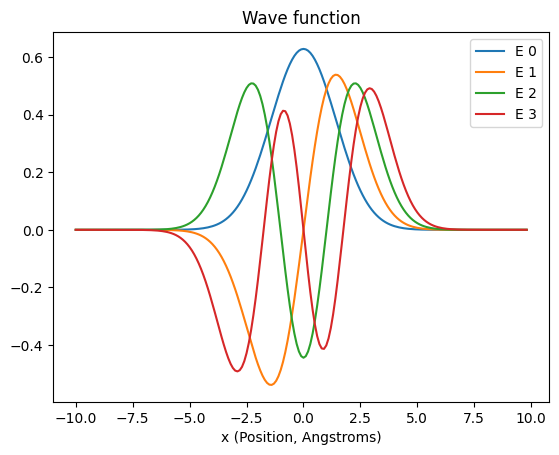

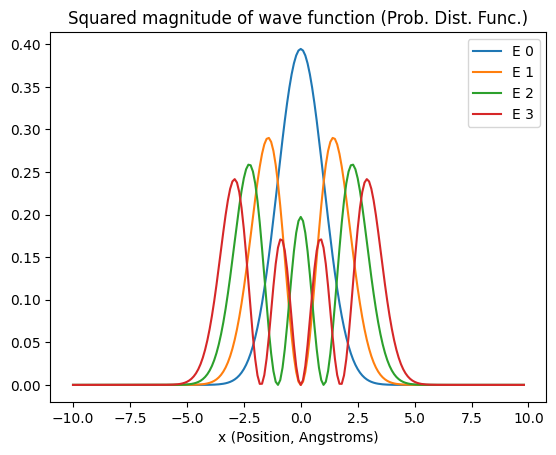

In [178]:
from math import sqrt
import matplotlib.pyplot as plt
from scipy import integrate

# Normalize and then plot solutions for the specified energy levels.
# Normalization is done such that the integral of the squared normalized
# solutions on the interval interval_for_sol equals one. (To save time, 
# we don't normalize solutions that won't be displayed.) Note that the 
# energy levels returned by linalg.eig aren't ordered from smallest to 
# largest by magnitude. Thus we use argsort to find the permutation of 
# indices that would rearrange the energy levels in this way, and then 
# we use these indices to find the corresponding eigenvectors for the 
# specified energy levels. Then we plot the components of these 
# eigenvectors. Also, this prints the amount of energy (in 
# electronvolts) that the particle has at each energy level.
print('Energy levels: (in electron volts)')

srt_ham_egv = hamiltonian_eigenvals.argsort()

# A list containing normalized solutions/wavefunctions. The element at
# the ith index of this list should be a numpy array containing the
# solution for the ith energy level.
normalized_solns = []

for e_lvl, egv_index in enumerate(srt_ham_egv.take(energy_levels_to_plot)):
    # Convert meters to Angstroms
    grid_points_A = grid_points * 1e10
    soln_int = integrate.simpson(
        hamiltonian_eigenvects[:, egv_index]**2, grid_points_A)
    normalized_solns.append(
        hamiltonian_eigenvects[:, egv_index]/sqrt(soln_int))

for e_lvl, egv_index in enumerate(srt_ham_egv.take(energy_levels_to_plot)):
    # Convert Joules to electron volts
    print('Energy level {}: {}'
          .format(e_lvl, abs(hamiltonian_eigenvals[egv_index] *
                             6.241_509_074e18)))
    # Convert meters to Angstroms
    plt.plot(grid_points * 1e10,
             normalized_solns[e_lvl], label='E {}'.format(e_lvl))

plt.xlabel('x (Position, Angstroms)')
plt.title('Wave function')
plt.legend()
plt.show()

for e_lvl, egv_index in enumerate(srt_ham_egv.take(energy_levels_to_plot)):
    # Convert meters to Angstroms
    plt.plot(grid_points * 1e10,
             normalized_solns[e_lvl]**2, label='E {}'.format(e_lvl))

plt.xlabel('x (Position, Angstroms)')
plt.title('Squared magnitude of wave function (Prob. Dist. Func.)')
plt.legend()
